 데이터셋 : 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.
 
 # 1) 데이터 준비와 확인

In [1]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [2]:
# import

import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#  2) 데이터로더 구성

IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일
* data_loader 작성

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [15]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #1 중복제거
    train_data = train_data.dropna(how = 'any')                   #2 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #3 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #4 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() #5 사전 word_to_index 구성
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]  # 앞에 <PAD> <BOS> <UNK> 추가 할수 있도록
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist): #6 텍스트 스트링을 인덱스 스트링 변환 i eat lunch - > [1, 3, 5, 7]
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index #7 리턴값
     
x_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
# <PAD>, <BOS>, <UNK> 추가
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [6]:
# 인덱스 -> word 변환
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
#  데이터셋 내 문장 길이 분포
# 적절한 최대 문장 길이 지정

# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일

total_data_text = list(x_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


# 4) 모델 구성 및 validation set 구성


In [10]:
# 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 적절한 validation 데이터는 몇 개가 좋을지 고민

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# 5) 모델 훈련 개시
# 6) Loss, Accuracy 그래프 시각화

In [11]:
# 어 사전의 크기를 지정해주고 한 단어를 표현하는 임베딩 벡터의 차원의 개수 설정

vocab_size = 10000  # 단어 사전의 크기를 지정
word_vector_dim = 4   # 한 단어를 표현하는 임베딩 벡터의 차원의 개수

# 5-1 1-D CNN

In [12]:
# 1-D CNN 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [13]:
# 1-D CNN 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 38s 4ms/step - loss: 0.4275 - accuracy: 0.7954 - val_loss: 0.3424 - val_accuracy: 0.8511
Epoch 2/5
2128/2128 [==============================] - 9s 4ms/step - loss: 0.3194 - accuracy: 0.8628 - val_loss: 0.3362 - val_accuracy: 0.8543
Epoch 3/5
2128/2128 [==============================] - 9s 4ms/step - loss: 0.2924 - accuracy: 0.8774 - val_loss: 0.3387 - val_accuracy: 0.8511
Epoch 4/5
2128/2128 [==============================] - 9s 4ms/step - loss: 0.2741 - accuracy: 0.8860 - val_loss: 0.3460 - val_accuracy: 0.8496
Epoch 5/5
2128/2128 [==============================] - 9s 4ms/step - loss: 0.2608 - accuracy: 0.8923 - val_loss: 0.3526 - val_accuracy: 0.8492


In [17]:
# 1-D CNN 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3630 - accuracy: 0.8470
[0.3629881739616394, 0.8469597697257996]


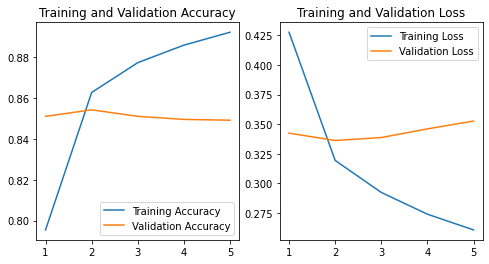

In [18]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5-2 GlobalMaxPooling1D 

In [20]:
# GlobalMaxPooling1D 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
# GlobalMaxPooling1D 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.5500 - accuracy: 0.7256 - val_loss: 0.4943 - val_accuracy: 0.7631
Epoch 2/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.4795 - accuracy: 0.7726 - val_loss: 0.4870 - val_accuracy: 0.7685
Epoch 3/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.4647 - accuracy: 0.7820 - val_loss: 0.4874 - val_accuracy: 0.7680
Epoch 4/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.4568 - accuracy: 0.7855 - val_loss: 0.4868 - val_accuracy: 0.7697
Epoch 5/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.4512 - accuracy: 0.7887 - val_loss: 0.4893 - val_accuracy: 0.7688


In [22]:
# GlobalMaxPooling1D 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4926 - accuracy: 0.7658
[0.49255678057670593, 0.7657912373542786]


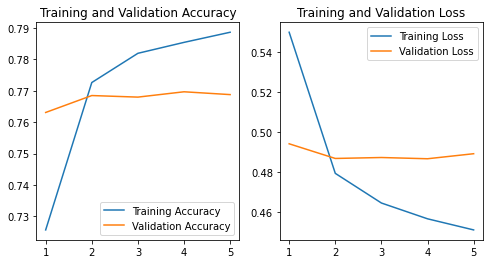

In [23]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5-3 LSTM레이어

In [24]:
# LSTM 레이어 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  #LSTM state 벡터의 차원수
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [25]:
# LSTM 레이어 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 16s 5ms/step - loss: 0.4262 - accuracy: 0.7888 - val_loss: 0.3595 - val_accuracy: 0.8421
Epoch 2/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3336 - accuracy: 0.8570 - val_loss: 0.3387 - val_accuracy: 0.8508
Epoch 3/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3144 - accuracy: 0.8660 - val_loss: 0.3390 - val_accuracy: 0.8535
Epoch 4/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2998 - accuracy: 0.8725 - val_loss: 0.3397 - val_accuracy: 0.8510
Epoch 5/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2858 - accuracy: 0.8777 - val_loss: 0.3346 - val_accuracy: 0.8565


In [26]:
# LSTM 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3432 - accuracy: 0.8504
[0.3432089686393738, 0.8504384160041809]


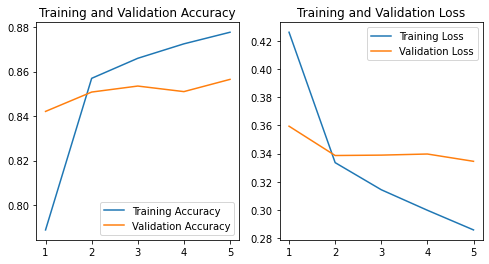

In [27]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 7) 학습된 Embedding 레이어 분석

In [28]:
# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # 출력 형태 : (vocab_size, embedding_dim)

(10000, 4)


In [29]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('007', 0.9966304302215576),
 ('드럼', 0.9949657917022705),
 ('생겼', 0.9923415184020996),
 ('진구', 0.9922713041305542),
 ('역설', 0.9896327257156372),
 ('제주도', 0.9894028902053833),
 ('지켜라', 0.9872114658355713),
 ('대표', 0.9865875244140625),
 ('이민정', 0.9862703680992126),
 ('ost', 0.9860069155693054)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [31]:
# ! pip install --upgrade gensim==3.8.3

In [32]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [33]:
# ko_model = 한국어 Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)

In [34]:
from gensim.models import KeyedVectors

# 유사한 단어와 그 유사도 확인
ko_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [38]:
ko_model['사랑'].shape

/tmp/ipykernel_1352/4192617215.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  ko_model['사랑'].shape


(200,)

In [39]:
# 이전 학습했던 모델의 임베딩 레이어를 ko_model 것으로 교체하여 다시 학습

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 ko_model 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/tmp/ipykernel_1352/1360978910.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_1352/1360978910.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


# 1. 1-D CNN

In [40]:
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_cnn=5
history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_cnn,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1064/1064 [==============================] - 7s 5ms/step - loss: 0.5410 - accuracy: 0.7370 - val_loss: 0.4327 - val_accuracy: 0.8263
Epoch 2/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.3850 - accuracy: 0.8476 - val_loss: 0.3748 - val_accuracy: 0.8474
Epoch 3/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.3267 - accuracy: 0.8711 - val_loss: 0.3551 - val_accuracy: 0.8496
Epoch 4/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2921 - accuracy: 0.8864 - val_loss: 0.3483 - val_accuracy: 0.8546
Epoch 5/5
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2641 - accuracy: 0.8994 - val_loss: 0.3468 - val_accuracy: 0.8557


In [43]:
results = model_cnn.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3599 - accuracy: 0.8518
[0.3599204421043396, 0.8517810106277466]


# 2. GlobalMaxPooling1D 

In [44]:
model_gmp = keras.Sequential()

model_gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_gmp.add(keras.layers.GlobalMaxPooling1D())
model_gmp.add(keras.layers.Dense(8, activation='relu'))
model_gmp.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_gmp=10
history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_gmp,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
2128/2128 [==============================] - 8s 3ms/step - loss: 0.5471 - accuracy: 0.7119 - val_loss: 0.4604 - val_accuracy: 0.7819
Epoch 2/10
2128/2128 [==============================] - 7s 3ms/step - loss: 0.4222 - accuracy: 0.8056 - val_loss: 0.4183 - val_accuracy: 0.8042
Epoch 3/10
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3751 - accuracy: 0.8335 - val_loss: 0.3914 - val_accuracy: 0.8228
Epoch 4/10
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3448 - accuracy: 0.8498 - val_loss: 0.3834 - val_accuracy: 0.8264
Epoch 5/10
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3183 - accuracy: 0.8639 - val_loss: 0.3933 - val_accuracy: 0.8265
Epoch 6/10
2128/2128 [==============================] - 7s 3ms/step - loss: 0.2962 - accuracy: 0.8756 - val_loss: 0.3793 - val_accuracy: 0.8355
Epoch 7/10
2128/2128 [==============================] - 7s 3ms/step - loss: 0.2759 - accuracy: 0.8862 - val_loss: 0.3891 - val_accuracy:

In [45]:
results3 = model_gmp.evaluate(x_test, y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.4299 - accuracy: 0.8259
[0.42992618680000305, 0.8258844017982483]


# 3. LSTM

In [46]:
model_lstm = keras.Sequential()

model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), 
                                  input_length=maxlen, trainable=True)) # trainable을 True로 주면 Fine-tuning
model_lstm.add(keras.layers.LSTM(8))          
model_lstm.add(keras.layers.Dense(4, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_lstm=5
history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_lstm,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1064/1064 [==============================] - 8s 6ms/step - loss: 0.5459 - accuracy: 0.6745 - val_loss: 0.3738 - val_accuracy: 0.8361
Epoch 2/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.3406 - accuracy: 0.8540 - val_loss: 0.3363 - val_accuracy: 0.8554
Epoch 3/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.3043 - accuracy: 0.8719 - val_loss: 0.3336 - val_accuracy: 0.8540
Epoch 4/5
1064/1064 [==============================] - 6s 5ms/step - loss: 0.2817 - accuracy: 0.8826 - val_loss: 0.3348 - val_accuracy: 0.8586
Epoch 5/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2622 - accuracy: 0.8916 - val_loss: 0.3381 - val_accuracy: 0.8561


In [47]:
results = model_lstm.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3488 - accuracy: 0.8521
[0.34881654381752014, 0.8521268367767334]


# 루브릭

|평가문항|상세기준|
|:---:|:---:|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

# 결과

|모델|임베딩 전|임베딩 후|
|----|--|--|
|1-D CNN|84.70%|85.18%|
|GlobalMaxpooling|76.58%|82.59%|
|LSTM|85.04%|85.21%|

1. 기초모델로 학습해도 높은 정확도가 나왔습니다
2. GlobalMaxPooling 이 낮은 걸로 보아 문자열의 관계에 초점을 맞춘 모델이 성능이 우수함을 보았습니다.
3. 한국어 Word2Vec을 활용하여 감정 분석의 정확도가 모두 높아져서 데이터 학습량의 필요성을 깨닫고 전이학습이 유리함을 확인하였습니다